In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# Any results you write to the current directory are saved as output.

In [2]:
# Optional: Print available computing resources
import multiprocessing
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')  # e.g. 4015976448
mem_gib = mem_bytes/(1024.**3)  # e.g. 3.74
print("COMPUTING RESOURCES: RAM: %f GB; CPU: %d CORES" % (mem_gib, multiprocessing.cpu_count()))


NameError: name 'os' is not defined

**Loading of data**

In [3]:
# list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../input/covid19-global-forecasting-week-3/train.csv
../input/covid19-global-forecasting-week-3/submission.csv
../input/covid19-global-forecasting-week-3/test.csv


In [4]:
train = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-3/train.csv")
test = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-3/test.csv")
print('Training data range: ',train.ix[0,'Date'],'..',train.ix[test.shape[0]-1,'Date'])
train.tail()

Training data range:  2020-01-22 .. 2020-03-29


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
23557,32708,NaN,Zimbabwe,2020-04-03,9.0,1.0
23558,32709,NaN,Zimbabwe,2020-04-04,9.0,1.0
23559,32710,NaN,Zimbabwe,2020-04-05,9.0,1.0
23560,32711,NaN,Zimbabwe,2020-04-06,10.0,1.0
23561,32712,NaN,Zimbabwe,2020-04-07,11.0,2.0


In [5]:
#Test data range: 26-03-2020..07-05-2020
print('Test data range: ',test.ix[0,'Date'],'..',test.ix[test.shape[0]-1,'Date'])
test.tail()

Test data range:  2020-03-26 .. 2020-05-07


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


,ForecastId,Province_State,Country_Region,Date
13153,13154,NaN,Zimbabwe,2020-05-03
13154,13155,NaN,Zimbabwe,2020-05-04
13155,13156,NaN,Zimbabwe,2020-05-05
13156,13157,NaN,Zimbabwe,2020-05-06
13157,13158,NaN,Zimbabwe,2020-05-07


**Data Summaries**

In [6]:
mask = train['Date'].max()
world_cum_confirmed = sum(train[train['Date'] == mask].ConfirmedCases)
world_cum_fatal = sum(train[train['Date'] == mask].Fatalities)
world_mortality_rate = world_cum_fatal / world_cum_confirmed

print('#Countries: ', len(train['Country_Region'].unique()))
print('Training dataset ending date: ', mask)
print('#Cumulative confirmed cases worldwide: ', world_cum_confirmed)
print('#Cumulative fatal cases worldwide: ', world_cum_fatal)
print('Mortality rate worlwide: ',world_mortality_rate)

# top 10 countires that have most servere situation
cum_per_country = train[train['Date'] == mask].groupby(['Date','Country_Region']).sum().sort_values(['ConfirmedCases'], ascending=False)
print('Top 10 most infected countries')
cum_per_country[:10]


#Countries:  180
Training dataset ending date:  2020-04-07
#Cumulative confirmed cases worldwide:  1425900.0
#Cumulative fatal cases worldwide:  81858.0
Mortality rate worlwide:  0.0574079528718704
Top 10 most infected countries


Id  ConfirmedCases  Fatalities
Date       Country_Region                                     
2020-04-07 US              1497771        396063.0     12717.0
           Spain             23296        141942.0     14045.0
           Italy             15592        135586.0     17127.0
           France           126495        110064.0     10343.0
           Germany           13559        107663.0      2016.0
           China            249711         82718.0      3335.0
           Iran              15164         62589.0      3872.0
           United Kingdom   314815         55947.0      6171.0
           Turkey            24794         34109.0       725.0
           Switzerland       23831         22253.0       821.0

Build Features

In [7]:
import numpy as np 
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

import time
from datetime import datetime

from pathlib import Path

from scipy import integrate, optimize

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

print("Loaded libraries")

Using TensorFlow backend.


Loaded libraries


In [8]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train['Country_Region'] = train['Country_Region'].astype(str)
# train['Province_State'] = train['Province_State'].astype(str)
test['Country_Region'] = test['Country_Region'].astype(str)
# test['Province_State'] = test['Province_State'].astype(str)
train.tail()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
23557,32708,NaN,Zimbabwe,2020-04-03,9.0,1.0
23558,32709,NaN,Zimbabwe,2020-04-04,9.0,1.0
23559,32710,NaN,Zimbabwe,2020-04-05,9.0,1.0
23560,32711,NaN,Zimbabwe,2020-04-06,10.0,1.0
23561,32712,NaN,Zimbabwe,2020-04-07,11.0,2.0


In [9]:
EMPTY_VAL = "EMPTY_VAL"

def fillState(state, country):
    if state == EMPTY_VAL: return country
    return state


train['Province_State'].fillna(EMPTY_VAL, inplace=True)
train['Province_State'] = train.loc[:, ['Province_State', 'Country_Region']].apply(lambda x : fillState(x['Province_State'], x['Country_Region']), axis=1)

test['Province_State'].fillna(EMPTY_VAL, inplace=True)
test['Province_State'] = test.loc[:, ['Province_State', 'Country_Region']].apply(lambda x : fillState(x['Province_State'], x['Country_Region']), axis=1)
train.tail()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
23557,32708,Zimbabwe,Zimbabwe,2020-04-03,9.0,1.0
23558,32709,Zimbabwe,Zimbabwe,2020-04-04,9.0,1.0
23559,32710,Zimbabwe,Zimbabwe,2020-04-05,9.0,1.0
23560,32711,Zimbabwe,Zimbabwe,2020-04-06,10.0,1.0
23561,32712,Zimbabwe,Zimbabwe,2020-04-07,11.0,2.0


In [10]:
le = preprocessing.LabelEncoder()
train['country_encoder'] = le.fit_transform(train['Country_Region'])
train['date_int'] = train['Date'].apply(lambda x: datetime.strftime(x, '%m%d')).astype(int)

test['country_encoder'] = le.transform(test['Country_Region'])
test['date_int'] = test['Date'].apply(lambda x: datetime.strftime(x, '%m%d')).astype(int)
train.tail()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country_encoder,date_int
23557,32708,Zimbabwe,Zimbabwe,2020-04-03,9.0,1.0,179,403
23558,32709,Zimbabwe,Zimbabwe,2020-04-04,9.0,1.0,179,404
23559,32710,Zimbabwe,Zimbabwe,2020-04-05,9.0,1.0,179,405
23560,32711,Zimbabwe,Zimbabwe,2020-04-06,10.0,1.0,179,406
23561,32712,Zimbabwe,Zimbabwe,2020-04-07,11.0,2.0,179,407


In [11]:
le = preprocessing.LabelEncoder()
train['province_encoder'] = le.fit_transform(train['Province_State'])
test['province_encoder'] = le.transform(test['Province_State'])
train.tail()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,country_encoder,date_int,province_encoder
23557,32708,Zimbabwe,Zimbabwe,2020-04-03,9.0,1.0,179,403,304
23558,32709,Zimbabwe,Zimbabwe,2020-04-04,9.0,1.0,179,404,304
23559,32710,Zimbabwe,Zimbabwe,2020-04-05,9.0,1.0,179,405,304
23560,32711,Zimbabwe,Zimbabwe,2020-04-06,10.0,1.0,179,406,304
23561,32712,Zimbabwe,Zimbabwe,2020-04-07,11.0,2.0,179,407,304


In [12]:
# Build features for training model
start_time = time.time()

country = train['Country_Region'].drop_duplicates()
train_df = train.copy()
train_df.rename(columns={'Date': 'date', 'ConfirmedCases': 'cc_cases', 'Fatalities': 'ft_cases', 'Country_Region': 'country', 'Province_State': 'province'}, inplace=True)
lags = np.arange(1,8,1)  # lag of 1 to 7

with tqdm(total = len(list(train_df['date'].unique()))) as pbar:
     for d in train_df['date'].drop_duplicates():
        for i in country:
            province = train_df[train_df['country'] == i]['province'].drop_duplicates()
            for j in province:
                mask = (train_df['date'] == d) & (train_df['country'] == i) & (train_df['province'] == j)            
                for lag in lags:
                    mask_org = (train_df['date'] == (d - pd.Timedelta(days=lag))) & (train_df['country'] == i) & (train_df['province'] == j)
                    try:
                        train_df.loc[mask, 'cc_cases_' + str(lag)] = train_df.loc[mask_org, 'cc_cases'].values
                    except:
                        train_df.loc[mask, 'cc_cases_' + str(lag)] = 0

                    try:
                        train_df.loc[mask, 'ft_cases_' + str(lag)] = train_df.loc[mask_org, 'ft_cases'].values
                    except:
                        train_df.loc[mask, 'ft_cases_' + str(lag)] = 0
        pbar.update(1)
print('Time spent for building features is {} minutes'.format(round((time.time()-start_time)/60,1)))

100%|██████████| 77/77 [45:44<00:00, 35.64s/it]

Time spent for building features is 45.7 minutes


In [13]:
train_df.to_csv(Path('/kaggle/working', 'train_df.csv')) 
# saved locally, reload it
#train_df = pd.read_csv(Path('/kaggle/input/', 'train_df.csv'), index_col = 0, parse_dates = ['date'])
train_df = train_df[train_df['date_int']>=301]  # cut off data after 301 to avoid most majority zeros
train_df['weekday'] = train_df['date'].dt.weekday
train_df[train_df['country'] == 'Italy'].tail(10)

,Id,province,country,date,cc_cases,ft_cases,country_encoder,date_int,province_encoder,cc_cases_1,...,ft_cases_3,cc_cases_4,ft_cases_4,cc_cases_5,ft_cases_5,cc_cases_6,ft_cases_6,cc_cases_7,ft_cases_7,weekday
11232,15583,Italy,Italy,2020-03-29,97689.0,10779.0,84,329,130,92472.0,...,8215.0,74386.0,7503.0,69176.0,6820.0,63927.0,6077.0,59138.0,5476.0,6
11233,15584,Italy,Italy,2020-03-30,101739.0,11591.0,84,330,130,97689.0,...,9134.0,80589.0,8215.0,74386.0,7503.0,69176.0,6820.0,63927.0,6077.0,0
11234,15585,Italy,Italy,2020-03-31,105792.0,12428.0,84,331,130,101739.0,...,10023.0,86498.0,9134.0,80589.0,8215.0,74386.0,7503.0,69176.0,6820.0,1
11235,15586,Italy,Italy,2020-04-01,110574.0,13155.0,84,401,130,105792.0,...,10779.0,92472.0,10023.0,86498.0,9134.0,80589.0,8215.0,74386.0,7503.0,2
11236,15587,Italy,Italy,2020-04-02,115242.0,13915.0,84,402,130,110574.0,...,11591.0,97689.0,10779.0,92472.0,10023.0,86498.0,9134.0,80589.0,8215.0,3
11237,15588,Italy,Italy,2020-04-03,119827.0,14681.0,84,403,130,115242.0,...,12428.0,101739.0,11591.0,97689.0,10779.0,92472.0,10023.0,86498.0,9134.0,4
11238,15589,Italy,Italy,2020-04-04,124632.0,15362.0,84,404,130,119827.0,...,13155.0,105792.0,12428.0,101739.0,11591.0,97689.0,10779.0,92472.0,10023.0,5
11239,15590,Italy,Italy,2020-04-05,128948.0,15887.0,84,405,130,124632.0,...,13915.0,110574.0,13155.0,105792.0,12428.0,101739.0,11591.0,97689.0,10779.0,6
11240,15591,Italy,Italy,2020-04-06,132547.0,16523.0,84,406,130,128948.0,...,14681.0,115242.0,13915.0,110574.0,13155.0,105792.0,12428.0,101739.0,11591.0,0
11241,15592,Italy,Italy,2020-04-07,135586.0,17127.0,84,407,130,132547.0,...,15362.0,119827.0,14681.0,115242.0,13915.0,110574.0,13155.0,105792.0,12428.0,1


**Building LSTM Model**

In [14]:
#TODO: walk forward validation
def split_train_val(df, val_ratio):
    val_len = int(len(df) * val_ratio)
    train_set =  df[:-val_len]
    val_set = df[-val_len:]
    return train_set, val_set

In [15]:
test_fixed_cols = ['ForecastId', 'Province_State', 'Country_Region', 'Date']
fixed_cols = ['Id', 'province', 'country', 'date']
output_cols = ['cc_cases', 'ft_cases']
input_cols = list(set(train_df.columns.to_list()) - set(fixed_cols) - set(output_cols))
print('output columns are ', output_cols)
print('input columns are ', input_cols)
X = train_df[input_cols]
y = train_df[output_cols]
X.tail()

output columns are  ['cc_cases', 'ft_cases']
input columns are  ['province_encoder', 'ft_cases_3', 'cc_cases_4', 'ft_cases_4', 'cc_cases_7', 'cc_cases_3', 'ft_cases_2', 'date_int', 'cc_cases_2', 'cc_cases_1', 'ft_cases_6', 'ft_cases_5', 'ft_cases_1', 'cc_cases_6', 'cc_cases_5', 'ft_cases_7', 'weekday', 'country_encoder']


,province_encoder,ft_cases_3,cc_cases_4,ft_cases_4,cc_cases_7,cc_cases_3,ft_cases_2,date_int,cc_cases_2,cc_cases_1,ft_cases_6,ft_cases_5,ft_cases_1,cc_cases_6,cc_cases_5,ft_cases_7,weekday,country_encoder
23557,304,1.0,7.0,1.0,5.0,8.0,1.0,403,8.0,9.0,1.0,1.0,1.0,7.0,7.0,1.0,4,179
23558,304,1.0,8.0,1.0,7.0,8.0,1.0,404,9.0,9.0,1.0,1.0,1.0,7.0,7.0,1.0,5,179
23559,304,1.0,8.0,1.0,7.0,9.0,1.0,405,9.0,9.0,1.0,1.0,1.0,7.0,8.0,1.0,6,179
23560,304,1.0,9.0,1.0,7.0,9.0,1.0,406,9.0,9.0,1.0,1.0,1.0,8.0,8.0,1.0,0,179
23561,304,1.0,9.0,1.0,8.0,9.0,1.0,407,9.0,10.0,1.0,1.0,1.0,8.0,9.0,1.0,1,179


In [16]:
# split to cumulative and fatal features and build 2 separate models
# split to train and validation set
cc_input = ['country_encoder', 'province_encoder', 'weekday', 'date_int','cc_cases_1', 'cc_cases_2', 'cc_cases_3', 'cc_cases_4', 'cc_cases_5', 'cc_cases_6', 'cc_cases_7'] # 'cc_cases_1', cc_cases_2', 'cc_cases_3', 'cc_cases_4', 'cc_cases_5', 'cc_cases_6', 'cc_cases_7', 'country_encoder', 'province_encoder', 'weekday' 
ft_input = ['country_encoder', 'province_encoder', 'weekday' , 'date_int', 'ft_cases_1', 'ft_cases_2', 'ft_cases_3', 'ft_cases_4', 'ft_cases_5', 'ft_cases_6', 'ft_cases_7'] #['ft_cases_1', 'ft_cases_2', 'ft_cases_3', 'ft_cases_4', 'ft_cases_5', 'ft_cases_6', 'ft_cases_7', 'country_encoder', 'province_encoder', 'weekday' 
cc_output = ['cc_cases']
ft_output = ['ft_cases']
val_ratio = 0.05
X_cc = X[cc_input]
X_ft = X[ft_input]
y_cc = y[cc_output]
y_ft = y[ft_output]
train_X_cc, val_X_cc = split_train_val(df = X_cc, val_ratio = val_ratio)
train_y_cc, val_y_cc = split_train_val(df = y_cc, val_ratio = val_ratio)
train_X_ft, val_X_ft = split_train_val(df = X_ft, val_ratio = val_ratio)
train_y_ft, val_y_ft = split_train_val(df = y_ft, val_ratio = val_ratio)

In [17]:
train_X_cc

,country_encoder,province_encoder,weekday,date_int,cc_cases_1,cc_cases_2,cc_cases_3,cc_cases_4,cc_cases_5,cc_cases_6,cc_cases_7
39,0,0,6,301,1.0,1.0,1.0,1.0,1.0,1.0,0.0
40,0,0,0,302,1.0,1.0,1.0,1.0,1.0,1.0,1.0
41,0,0,1,303,1.0,1.0,1.0,1.0,1.0,1.0,1.0
42,0,0,2,304,1.0,1.0,1.0,1.0,1.0,1.0,1.0
43,0,0,3,305,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
22391,172,28,0,323,6.0,2.0,2.0,2.0,0.0,0.0,0.0
22392,172,28,1,324,6.0,6.0,2.0,2.0,2.0,0.0,0.0
22393,172,28,2,325,6.0,6.0,6.0,2.0,2.0,2.0,0.0
22394,172,28,3,326,7.0,6.0,6.0,6.0,2.0,2.0,2.0


In [18]:
#shuffling
# idx = np.random.RandomState(seed=123).permutation(train_X_cc.index)
# train_X_cc = train_X_cc.reindex(idx)
# train_y_cc = train_y_cc.reindex(idx)
# train_X_ft = train_X_ft.reindex(idx)
# train_y_ft = train_y_ft.reindex(idx)
# train_y_cc.tail()

In [19]:
# normalization
X_scaler_cc = MinMaxScaler()
X_train_cc = X_scaler_cc.fit_transform(train_X_cc)
X_val_cc =  X_scaler_cc.transform(val_X_cc) # intput/output 2D array-like

y_scaler_cc = MinMaxScaler()
y_train_cc = y_scaler_cc.fit_transform(train_y_cc)
y_val_cc = y_scaler_cc.transform(val_y_cc) # array-like
X_train_cc

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        8.67739192e-06, 9.04371733e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.67739192e-06, 9.04371733e-06, 9.45251059e-06],
       [0.00000000e+00, 0.00000000e+00, 1.66666667e-01, ...,
        8.67739192e-06, 9.04371733e-06, 9.45251059e-06],
       ...,
       [1.00000000e+00, 9.24092409e-02, 3.33333333e-01, ...,
        1.73547838e-05, 1.80874347e-05, 0.00000000e+00],
       [1.00000000e+00, 9.24092409e-02, 5.00000000e-01, ...,
        1.73547838e-05, 1.80874347e-05, 1.89050212e-05],
       [1.00000000e+00, 9.24092409e-02, 6.66666667e-01, ...,
        5.20643515e-05, 1.80874347e-05, 1.89050212e-05]])

In [20]:
#Train model
X_scaler_ft = MinMaxScaler()
X_train_ft = X_scaler_ft.fit_transform(train_X_ft)
X_val_ft =  X_scaler_ft.transform(val_X_ft) # intput/output 2D array-like

y_scaler_ft = MinMaxScaler()
y_train_ft = y_scaler_ft.fit_transform(train_y_ft)
y_val_ft = y_scaler_ft.transform(val_y_ft) # array-like
X_val_ft

array([[1.00000000e+00, 9.24092409e-02, 8.33333333e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.24092409e-02, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.24092409e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.04069767e+00, 1.00330033e+00, 1.00000000e+00, ...,
        7.18648940e-05, 7.60167237e-05, 8.04634696e-05],
       [1.04069767e+00, 1.00330033e+00, 0.00000000e+00, ...,
        7.18648940e-05, 7.60167237e-05, 8.04634696e-05],
       [1.04069767e+00, 1.00330033e+00, 1.66666667e-01, ...,
        7.18648940e-05, 7.60167237e-05, 8.04634696e-05]])

In [21]:
print('Validate if train and test is splited correctly for 2 cases: ')
print('cumulative cases training has shape ', X_train_cc.shape, y_train_cc.shape)
print('fatal cases training has shape ', X_train_ft.shape, y_train_ft.shape)
print('cumulative cases valid has shape ', X_val_cc.shape, y_val_cc.shape)
print('fatal cases valid has shape ', X_val_ft.shape, y_val_ft.shape)
#TODO
print('Validate if train and test contains np.nan, np.inf, -np.inf after standardization: ')

Validate if train and test is splited correctly for 2 cases: 
cumulative cases training has shape  (11047, 11) (11047, 1)
fatal cases training has shape  (11047, 11) (11047, 1)
cumulative cases valid has shape  (581, 11) (581, 1)
fatal cases valid has shape  (581, 11) (581, 1)
Validate if train and test contains np.nan, np.inf, -np.inf after standardization: 


In [22]:
# # if choose to not apply normalization, however it generates NaN in output...
# X_train_cc = train_X_cc.to_numpy()  
# X_val_cc = val_X_cc.to_numpy()
# X_train_ft = train_X_ft.to_numpy()
# X_val_ft = val_X_ft.to_numpy()

# y_train_cc = train_y_cc.to_numpy()
# y_val_cc = val_y_cc.to_numpy()
# y_train_ft = train_y_ft.to_numpy()
# y_val_ft = val_y_ft.to_numpy()

In [23]:
# for LSTM, intput.shape = (n_samples, 1, n_features)
X_train_cc = X_train_cc.reshape(X_train_cc.shape[0], 1, X_train_cc.shape[1])
X_val_cc = X_val_cc.reshape(X_val_cc.shape[0], 1, X_val_cc.shape[1])

X_train_ft = X_train_ft.reshape(X_train_ft.shape[0], 1, X_train_ft.shape[1])
X_val_ft = X_val_ft.reshape(X_val_ft.shape[0], 1, X_val_ft.shape[1])
print(X_train_cc.shape, X_val_cc.shape, X_train_ft.shape, X_val_ft.shape)

(11047, 1, 11) (581, 1, 11) (11047, 1, 11) (581, 1, 11)


In [24]:
# customize loss function which is aligned with kaggle evaluation
def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [25]:
#declaring only one model
def LSTM_model(n_1, input_dim, output_dim):
    model = Sequential()
    model.add(LSTM(n_1,input_shape=(1, input_dim), activation='relu'))
    # model.add(LSTM(n_2, activation='relu'))
    model.add(Dense(output_dim, activation='relu'))
    # adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss=root_mean_squared_log_error, optimizer='adam')
    # print(model.summary())
    return model

In [26]:
K.clear_session()   
model_cc = LSTM_model(4, X_train_cc.shape[-1], y_train_cc.shape[-1])
model_ft = LSTM_model(4, X_train_ft.shape[-1], y_train_ft.shape[-1])
early_stop_cc = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
early_stop_ft = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
print('Settings completed')

Settings completed


In [27]:
#TODO: debug sometimes it's getting inf. Suspect bad input
print('Start model training')
start_time = time.time()
history_cc = model_cc.fit(X_train_cc, y_train_cc, batch_size = 16, epochs = 100,validation_data = (X_val_cc, y_val_cc), verbose = 2, callbacks=[early_stop_cc])
model_cc.save("model_cc.h5")
print('Time spent for model training is {} minutes'.format(round((time.time()-start_time)/60,1)))

Start model training
Train on 11047 samples, validate on 581 samples
Epoch 1/100
 - 2s - loss: 0.0282 - val_loss: 0.0068
Epoch 2/100
 - 1s - loss: 0.0282 - val_loss: 0.0068
Epoch 3/100
 - 1s - loss: 0.0280 - val_loss: 0.0068
Epoch 4/100
 - 1s - loss: 0.0280 - val_loss: 0.0068
Epoch 5/100
 - 1s - loss: 0.0283 - val_loss: 0.0068
Epoch 6/100
 - 1s - loss: 0.0284 - val_loss: 0.0068
Time spent for model training is 0.2 minutes


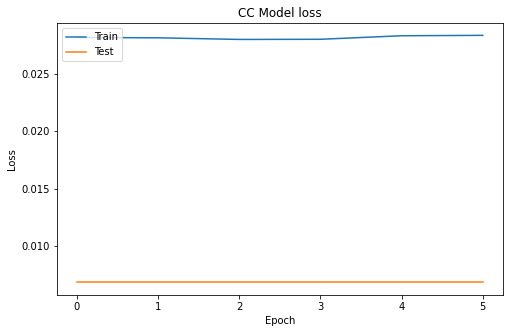

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history_cc.history['loss'])
plt.plot(history_cc.history['val_loss'])
plt.title('CC Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
print('Start model training')
start_time = time.time()
history_ft = model_ft.fit(X_train_ft, y_train_ft, batch_size = 16, epochs = 8,validation_data = (X_val_ft, y_val_ft), verbose = 2, callbacks=[early_stop_ft])
model_ft.save("model_ft.h5")
print('Time spent for model training is {} minutes'.format(round((time.time()-start_time)/60,1)))

Start model training
Train on 11047 samples, validate on 581 samples
Epoch 1/8
 - 2s - loss: 0.0129 - val_loss: nan
Epoch 2/8
 - 1s - loss: nan - val_loss: nan
Epoch 3/8
 - 1s - loss: nan - val_loss: nan
Epoch 4/8
 - 1s - loss: nan - val_loss: nan
Epoch 5/8
 - 1s - loss: nan - val_loss: nan
Time spent for model training is 0.1 minutes


In [30]:
# Validate if output makes sense
yhat_val_cc = model_cc.predict(X_val_cc)
print('Actual: ',y_val_cc[50:70])
print('Predicted: ',yhat_val_cc[50:70])

Actual:  [[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.04513111e-06]
 [7.04513111e-06]
 [7.04513111e-06]
 [7.04513111e-06]
 [7.04513111e-06]
 [7.04513111e-06]
 [2.11353933e-05]
 [2.11353933e-05]
 [2.11353933e-05]]
Predicted:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [31]:
# Validate if output makes sense
print('Actual: ',list(y_val_cc[50:60]))
yhat_val_ft = model_ft.predict(X_val_ft)
print('Predicted: ',yhat_val_ft[50:60])

Actual:  [array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]
Predicted:  [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]


**Generate predictions**

In [32]:
#TODO: takes 14m ish, consider multi-processing, multi-cores, run in GPU
#TODO: create data_generate func
start_time = time.time()
test['Country_Region'] = test['Country_Region'].astype(str)
test['Province_State'] = test['Province_State'].astype(str)
country = test['Country_Region'].drop_duplicates()
adj_input_cols = [e for e in input_cols if e not in ('province_encoder', 'country_encoder', 'date_int')]
# fill data for overlapped days
test_df = test.copy().join(pd.DataFrame(columns = adj_input_cols + output_cols))
test_df['weekday'] = test_df['Date'].dt.weekday
test_df.rename(columns={'Date': 'date', 'Country_Region': 'country', 'Province_State': 'province'}, inplace=True)
lags = np.arange(1,8,1)  # lag of 1 to 7
test_overlap_mask = (test_df['date'] <= train_df['date'].max())
train_overlap_mask = (train_df['date'] >= test_df['date'].min())
test_df.loc[test_overlap_mask, input_cols + output_cols] = train_df.loc[train_overlap_mask, input_cols + output_cols].values

# predict data for forward days
pred_dt_range = pd.date_range(start = train_df['date'].max() + pd.Timedelta(days=1), end = test_df['date'].max(), freq = '1D') # test_df['date'].max()
with tqdm(total = len(pred_dt_range)) as pbar:
    for d in pred_dt_range:
        
        for i in country:
            
            province = test_df[test_df['country'] == i]['province'].drop_duplicates()
            
            for j in province:
                
                mask = (test_df['date'] == d) & (test_df['country'] == i) & (test_df['province'] == j)
                
                
                # update input features for the predicted day
                for lag in lags:
                    mask_org = (test_df['date'] == (d - pd.Timedelta(days=lag))) & (test_df['country'] == i) & (test_df['province'] == j)
                    try:
                        test_df.loc[mask, 'cc_cases_' + str(lag)] = test_df.loc[mask_org, 'cc_cases'].values
                    except:
                        test_df.loc[mask, 'cc_cases_' + str(lag)] = 0

                    try:
                        test_df.loc[mask, 'ft_cases_' + str(lag)] = test_df.loc[mask_org, 'ft_cases'].values
                    except:
                        test_df.loc[mask, 'ft_cases_' + str(lag)] = 0
                
                test_X  = test_df.loc[mask, input_cols]
            
                # predict for comfirmed cases
                test_X_cc = test_X[cc_input]
                X_test_cc= test_X_cc
                # X_test_cc =  X_scaler_cc.transform(test_X_cc) # intput/output 2D array-like
                # X_test_cc = X_test_cc.reshape(X_test_cc.shape[0], 1, X_test_cc.shape[1])
                X_test_cc = X_test_cc.to_numpy().reshape(X_test_cc.shape[0], 1, X_test_cc.shape[1])
                next_cc = model_cc.predict(X_test_cc)
                # next_cc_scaled = y_scaler_cc.inverse_transform(next_cc)
                next_cc_scaled = next_cc
                
                # predict for fatal cases
                test_X_ft = test_X[ft_input]
                X_test_ft = test_X_ft
                # X_test_ft =  X_scaler_ft.transform(test_X_ft) # intput/output 2D array-like
                # X_test_ft = X_test_ft.reshape(X_test_ft.shape[0], 1, X_test_ft.shape[1])
                X_test_ft = X_test_ft.to_numpy().reshape(X_test_ft.shape[0], 1, X_test_ft.shape[1])
                next_ft = model_cc.predict(X_test_ft)
                # next_ft_scaled = y_scaler_cc.inverse_transform(next_ft)
                next_ft_scaled = next_ft
                # print(d, ' - ', i, ' - ', j,  ' - Predicted Confirmed Cases are ', next_cc_scaled, ' - Predicted Fatal Cases are ', next_ft_scaled)
                
                # update yhat for next day
                test_df.loc[mask, 'cc_cases'] = next_cc_scaled
                test_df.loc[mask, 'ft_cases'] = next_ft_scaled
                        
        pbar.update(1)
        
print('Time spent for building features is {} minutes'.format(round((time.time()-start_time)/60,1)))

100%|██████████| 30/30 [16:26<00:00, 32.88s/it]

Time spent for building features is 16.4 minutes


In [33]:
submission = pd.DataFrame()
submission['ForecastId'] = test_df['ForecastId']
submission['ConfirmedCases'] = test_df['cc_cases']
submission['Fatalities'] = test_df['ft_cases']
submission.sample()

,ForecastId,ConfirmedCases,Fatalities
9211,9212,977,22


In [34]:
submission.to_csv("submission.csv",index=False)

In [35]:
submission[:20]

,ForecastId,ConfirmedCases,Fatalities
0,1,94,4
1,2,110,4
2,3,110,4
3,4,120,4
4,5,170,4
5,6,174,4
6,7,237,4
7,8,273,6
8,9,281,6
9,10,299,7
